In [35]:
# Imports
import networkx as nx
import matplotlib.pyplot as plt
import math
import csv
import time
import colorsys
import warnings

In [36]:
# Create graph object from data
def init_graph(datasource_dir: str, selected_user: str) -> nx.Graph:
	graph = nx.Graph()
	nodes_size: dict[str,int] = dict()

	# Extract file
	with open(f"{datasource_dir}/comparisons.csv", encoding='UTF-8') as csvfile:
		rows = csv.DictReader(csvfile)
		
		for row in rows:
			try:
				if row['criteria'] != 'largely_recommended':
					continue

				nodes_size[row['video_a']] = nodes_size.get(row['video_a'],0) + 1
				nodes_size[row['video_b']] = nodes_size.get(row['video_b'],0) + 1

				if row['public_username'] != selected_user:
					continue

				if not graph.has_edge(row['video_a'], row['video_b']):
					graph.add_edge(row['video_a'], row['video_b'], spring=1)
				else:
					graph[row['video_a']][row['video_b']]['spring'] += 1
			except Exception as e:
				print(row)
				raise e

	print('Loaded', graph)

	# Add nodes size to metadata
	for n in graph.nodes:
		graph.nodes[n]['size'] = nodes_size.get(n, 1)

	# Keep only largest connected subgraph
	largest_group = max(nx.connected_components(graph), key=len)
	graph.remove_nodes_from(n for n in list(graph.nodes) if not n in largest_group)
	print('Largest connected subgraph:', graph)

	return graph

In [37]:
# Display graph
def get_graph_layout(graph: nx.Graph, max_duration: int):
	print('Preparing graph layout')
	start = time.time()

	# Initialy put all nodes in a circle around the center
	pos=nx.circular_layout(graph)

	iterations_count=10
	total_iterations=0
	timer_a = time.time()
	loops_count = 0
	while timer_a - start < max_duration:
		loops_count += 1
		# Move nodes towards eachother if connected, move them apart from eachother if not connected
		pos = nx.spring_layout(graph, pos=pos, weight='spring', iterations=iterations_count)
		total_iterations += iterations_count
		timer_b = time.time()
		speed = iterations_count / (timer_b-timer_a)
		expected_remaining_iterations = speed * (max_duration - timer_b + start)
		print(f"Iterations: {total_iterations}/{total_iterations + expected_remaining_iterations:.0f} -- Time: {timer_b-start:.1f}/{max_duration}s -- Speed: {speed:.1f}/s")
		next_iteration_count = int(math.ceil(expected_remaining_iterations / (10 - loops_count if loops_count < 10 else 1)))
		if next_iteration_count > iterations_count*2 and loops_count > 1:
			# Spring Layout may stop iterating if found an equilibrium. Try to detect this event and stop before max_duration
			break
		# Prepare next iteration
		iterations_count = next_iteration_count
		timer_a = timer_b

	end = time.time()
	print()
	print(f"{total_iterations} spring iterations in {end-start:0.3f}s")
	return pos

def weight_to_color(weight, min_c:float, mm_c:float):
	return colorsys.hsv_to_rgb((weight-min_c)/mm_c * (128/360), .9, .9)

def draw_graph(graph: nx.Graph, pos):
	# Order nodes by color
	colors_map = {n: len(graph[n]) for n in graph.nodes}
	nodes = sorted(graph.nodes, key=colors_map.get)
	sorted_graph = nx.Graph()
	sorted_graph.add_nodes_from(nodes)
	sorted_graph.add_edges_from(graph.edges.data())

	# node color
	min_c = min(colors_map.values())
	mm_c = max(colors_map.values()) - min_c
	print('min & max colors:', min_c, min_c + mm_c)
	colors = [weight_to_color(colors_map[n], min_c, mm_c) for n in nodes]

	# Prepare image
	plt.box(False)
	plt.clf()
	plt.tight_layout()
	plt.rcParams['svg.fonttype'] = 'none'
	plt.rc('axes', unicode_minus=False)

	# Output svg dimensions
	size = (sorted_graph.number_of_nodes()+1)**0.25
	print(f"Image size: {size*1.4+1:.1f}x{size+1:.1f}")
	fig = plt.figure(figsize=(size*1.4+1, size+1), frameon=False)

	# Axis
	fig.clear()
	ax = fig.add_axes([0, 0, 1, 1])
	ax.axis('off')
	ax.set_facecolor('#FFF') # Background color

	nodes_width = dict(graph.nodes(data="size"))
	min_w = min(nodes_width.values())
	mm_w = max(nodes_width.values()) - min_w
	min_display = 1
	mm_display = 25 - min_display
	nx.draw_networkx_nodes(sorted_graph,
		pos=pos,
		nodelist=nodes,
		node_size=[min_display+mm_display*(nodes_width[n]-min_w)/mm_w for n in nodes],
		node_color=colors
	)

	nx.draw_networkx_edges(sorted_graph,
		pos=pos,
		edge_color='#8888',
		width=0.5,
	)

	warnings.filterwarnings("ignore", category=UserWarning)

Loaded Graph with 3610 nodes and 8667 edges
Largest connected subgraph: Graph with 3608 nodes and 8666 edges
Preparing graph layout
Iterations: 10/143 -- Time: 8.4/120s -- Speed: 1.2/s
Iterations: 25/145 -- Time: 20.8/120s -- Speed: 1.2/s
Iterations: 40/146 -- Time: 33.1/120s -- Speed: 1.2/s
Iterations: 56/140 -- Time: 47.0/120s -- Speed: 1.1/s
Iterations: 70/136 -- Time: 59.8/120s -- Speed: 1.1/s
Iterations: 84/141 -- Time: 71.7/120s -- Speed: 1.2/s
Iterations: 99/138 -- Time: 85.0/120s -- Speed: 1.1/s
Iterations: 113/139 -- Time: 97.4/120s -- Speed: 1.1/s
Iterations: 126/138 -- Time: 109.0/120s -- Speed: 1.1/s
Iterations: 139/138 -- Time: 120.5/120s -- Speed: 1.1/s

139 spring iterations in 120.460s
min & max colors: 1 29
Image size: 11.9x8.8


<Figure size 640x480 with 0 Axes>

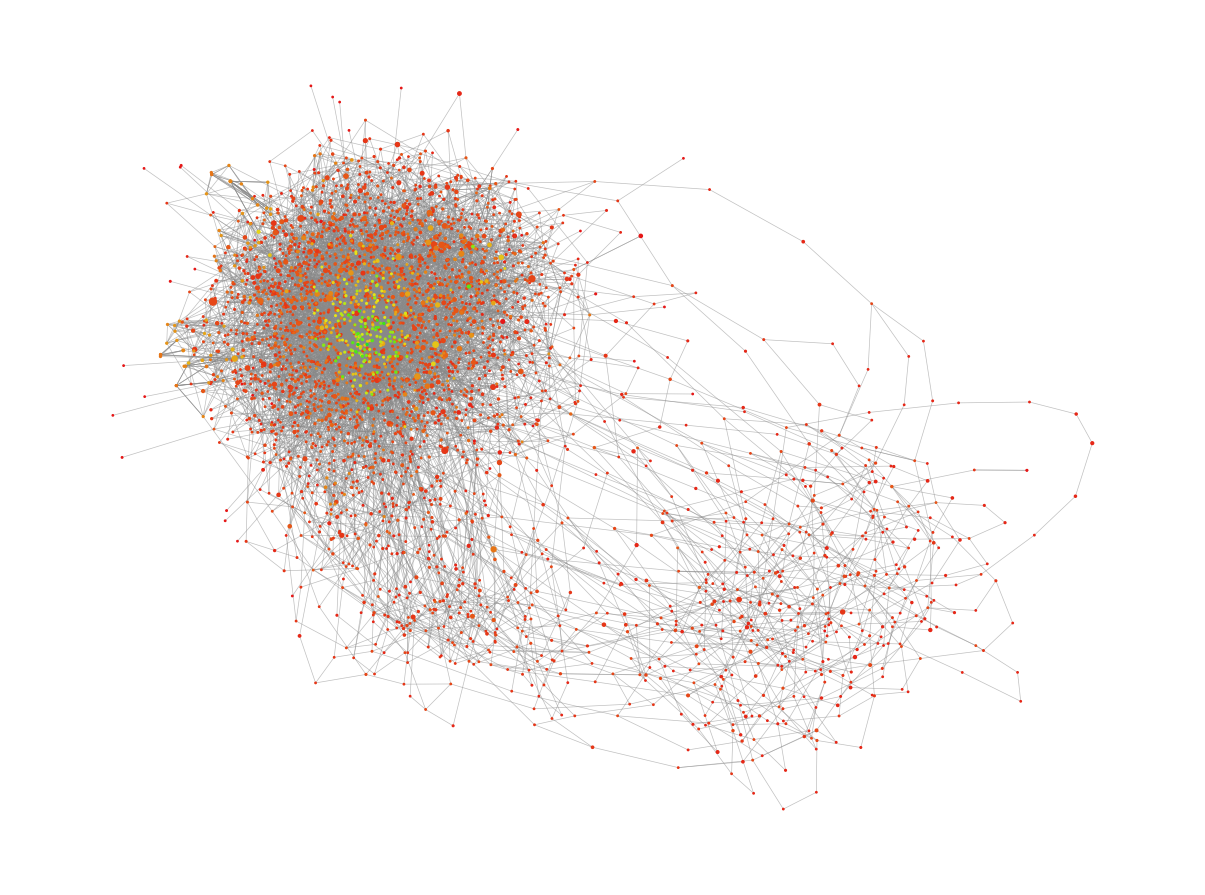

In [41]:
## EXECUTION
DATASOURCE_DIR='C:\\Users\\natngs\\Documents\\#Prog\\Tournesol-Stats\\data\\input\\tournesol_dataset_2024-02-12'
USER='lpfaucon'
GRAPH = init_graph(DATASOURCE_DIR, USER)
TIME_TO_RUN=120 # Seconds, the longer the prettier (but the more time it will take to compute)
pos = get_graph_layout(GRAPH, TIME_TO_RUN)
draw_graph(GRAPH, pos)